# 本次分析目标
# 全球交通运输分析概述

为了方便游客们出行，选择出行方式时，能够考虑到交通的各种情况，作此分析

## 分析内容

### 1. 交通方式的枢纽数量对比
- **航空**：全球各地的航空公司和机场
- **海运**：全球各地的轮渡码头
- **陆路**：全球各地的火车站

### 2. 各交通方式的主要公司或景点
- 调查哪种交通方式拥有最多的景点或公司。

### 3. 航空公司路线显示
- 展示不同航空公司的航线网络图。

### 4. 最繁忙的机场及其主要航空公司
- 分析哪家航空公司在特定机场的使用频率最高。

## 数据可视化

### 1. 世界地图上的交通枢纽
- 展示三种交通方式的枢纽在世界地图上的分布情况。
- 每种交通方式的枢纽数量。

### 2. 交通枢纽的直方图
- 制作直方图，展示顶部条目，即最繁忙的机场、最常用的轮渡码头和最繁忙的火车站。

### 3. 枢纽的地理位置绘图
- 绘制所有国家/地区的交通枢纽地理位置图。
- 提供一个国家/地区的详细枢纽分布图。

In [1]:
options(width=100)
knitr::opts_chunk$set(out.width='1000px',dpi=200,message=FALSE,warning=FALSE)

In [2]:
library(ggplot2)
library(dplyr)
library(gridExtra)
library(grid)
library(RColorBrewer)
library(ggrepel)
library(ggthemes)
library(viridis)

Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Warning message:
"package 'dplyr' was built under R version 4.3.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'gridExtra' was built under R version 4.3.3"

Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Warning message:
"package 'ggrepel' was built under R version 4.3.3"
Warning message:
"package 'ggthemes' was built under R version 4.3.3"
Warning message:
"package 'viridis' was built under R version 4.3.3"
Loading required package: viridisLite

Warning message:
"package 'viridisLite' was built under R version 4.3.3"


后续分析中我们使用了三个数据集：
- routes.csv:包含所有带有airport.start、airport.end和一些其他元数据的路线（机场代码：IATA）
- airports.csv：包含所有机场的特征（城市名称、地理位置…）
- airlines.csv：包含每家航空公司的特征

In [3]:
routes<-read.csv("routes.csv",sep=',',stringsAsFactors=F)
#rename column
colnames(routes)[1]<-'IATA'
#fix typo
colnames(routes)[5]<-'destination.airport'

airports<-read.csv("airports-extended.csv",sep=",",stringsAsFactors=F,header=F)
colnames(airports)<-c("id","airport.name",'city.name','country.name','IATA','ICAO','lat','long','altitude','tz.offset','DST','tz.name','airport.type','source.data')
airports[airports$country.name=='United States','country.name']<-'USA'
airports[airports$country.name=='United Kingdom','country.name']<-'UK'
airports[airports$country.name=='Cote d\'Ivoire','country.name']<-'Ivory Coast'
airports[airports$country.name=='Congo (Kinshasa)','country.name']<-'Democratic Republic of the Congo'
airports[airports$country.name=='Congo (Brazzaville)','country.name']<-'Republic of Congo'

airlines<-read.csv('airlines.csv',sep=',',stringsAsFactors=F,header=T)

#merge routes and airline data
routes<-data.frame(merge(routes, airlines %>% select(IATA, Name), by='IATA',sort=F))

1.Code for a Map
- 以世界地图为基准作图

In [4]:
countries_map <-map_data("world")
world_map<-ggplot() + 
  geom_map(data = countries_map, 
           map = countries_map,aes(x = long, y = lat, map_id = region, group = group),
           fill = "white", color = "black", size = 0.1)

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
Warning message in geom_map(data = countries_map, map = countries_map, aes(x = long, :
"Ignoring unknown aesthetics: x and y"


makeMapType用来创建和显示基于不同类型的地理位置数据的地图

In [5]:
makeMapType<-function(type){
    # 筛选数据的类型按照country_name进行分组后，用count=n()function进行汇总
    # 将country.name更名为region
    # arrange（-count）降序排列
    temp <-data.frame(airports %>% dplyr::filter(airport.type==type) %>% dplyr::group_by(country.name) %>% dplyr::summarize(count=n()) %>% dplyr::rename(region=country.name) %>% dplyr::arrange(-count))
   
    # 将汇总后的数据与全球国家的地图数据进行左连接
    res<-data.frame(left_join(countries_map,temp,by='region'))
    
    pal='D'
    
    if(type=='airport'){
        #设置颜色的断点和标签
        breaks = c(exp(0),exp(6.90),exp(7.60))
        labels = c(1,100,2000)
        max<-2000
    } else if(type=='port'){
        breaks = c(exp(0),exp(1.60),exp(3.40))
        labels = c(1,5,30)
        max<-30
    } else if(type=='station'){
        breaks = c(exp(0),exp(2.30),exp(5.99))
        labels = c(1,10,400)
        max<-400
        }
    
    listPlot<-list()
    # geom_polygon用于绘制多边形，aes()定义了如何将数据映射到图形属性上
    # scale_fill_viridis使用Viridis色板来映射数据的'fill'属性，即多边形的颜色
    # theme_fivethirtyeight和theme调整图例位置和样式等等
    listPlot[[1]]<- ggplot() + geom_polygon(data=res,aes(x = long, y = lat, group = group,fill=count),colour = "white", size = 0.1) + 
    scale_fill_viridis(name=paste0("number of ",type), option = pal, direction = 1,na.value = "grey40",limits = c(0, max),
    breaks = breaks, labels = labels) + 
    theme_fivethirtyeight() + 
    theme(legend.position=c(.85,1.05),
        legend.text=element_text(size=8),
        panel.grid.major = element_blank(),
        axis.text=element_blank(),
        axis.ticks=element_blank(),
        plot.title=element_text(face="bold",hjust=.012,vjust=.8,colour="#3C3C3C",size=20),
        plot.subtitle=element_text(size=10, hjust=0, face="italic", color="black")) + 
        labs(
        title=paste0("Map of ",type,"s by Country"),
        subtitle="Bottom right histogram representing the top 10 Countries\nNote the log scale for the color map\nMissing data in gray")
           listPlot[[2]]<-temp %>% arrange(-count) %>% head(10) %>%ggplot(aes(x=reorder(region,count),y=count)) + geom_histogram(stat='identity') + coord_flip() + theme_fivethirtyeight() + theme(axis.text.y = element_text(size=8))
       
       return(listPlot)
}

机场分布图

In [6]:
airport_type <- makeMapType('airport')

Warning message:
"A numeric `legend.position` argument in `theme()` was deprecated in ggplot2 3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead."
Warning message in geom_histogram(stat = "identity"):
"Ignoring unknown parameters: `binwidth`, `bins`, and `pad`"


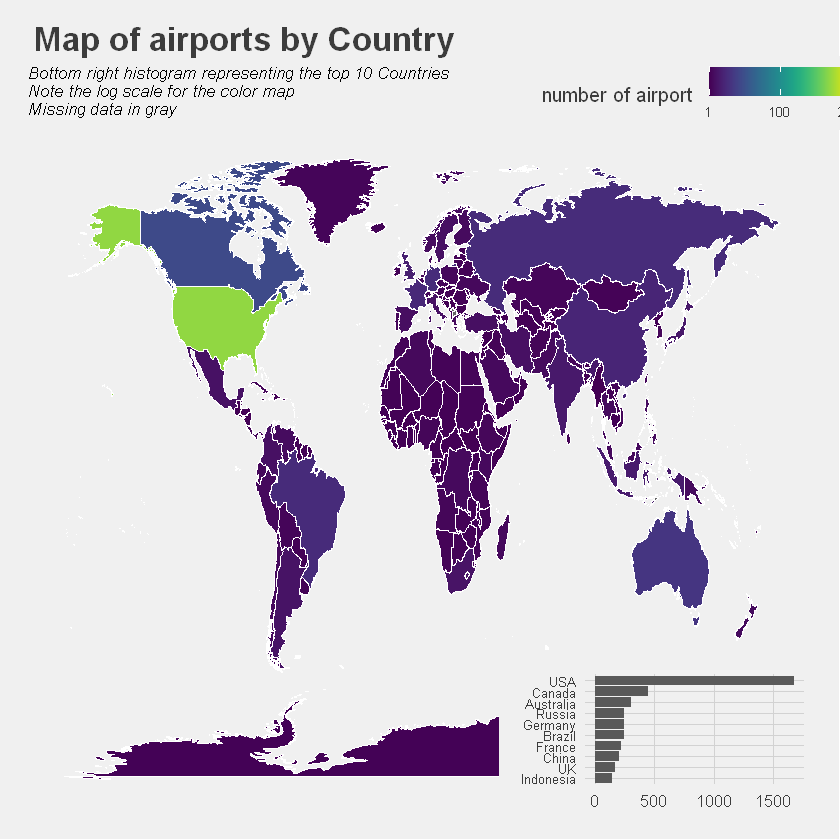

In [7]:
airport_type[[1]] + annotation_custom(grob = ggplotGrob(airport_type[[2]]), xmin = 45, xmax = 215, ymin = -100, ymax = -50)

- 数量分布存在很大偏差
- 数据在一些国家上存在少计情况
- 美国拥有1500多家机场

Ports

In [8]:
port_type <- makeMapType('port')

Warning message in geom_histogram(stat = "identity"):
"Ignoring unknown parameters: `binwidth`, `bins`, and `pad`"


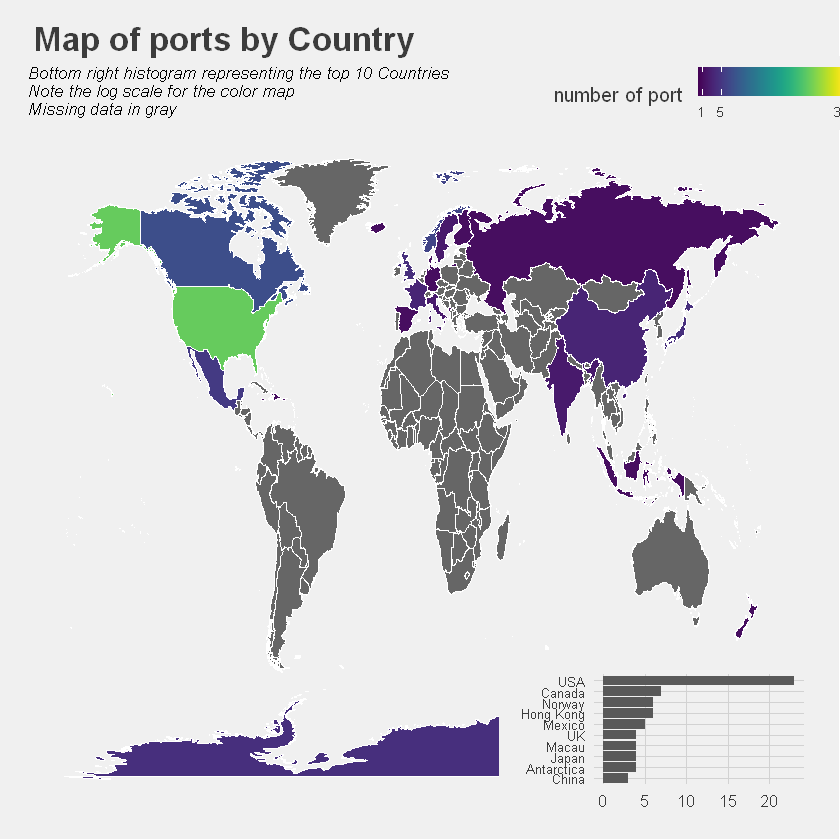

In [9]:
port_type[[1]] + annotation_custom(grob = ggplotGrob(port_type[[2]]), xmin = 45, xmax = 215, ymin = -100, ymax = -50)

- 与机场地图的报道相同，美国再次成为主导国家
- 我们还看到其他具有海运/商业历史背景的预期国家（中国、挪威）紧随其后

火车站

In [10]:
station_type <- makeMapType('station')

Warning message in geom_histogram(stat = "identity"):
"Ignoring unknown parameters: `binwidth`, `bins`, and `pad`"


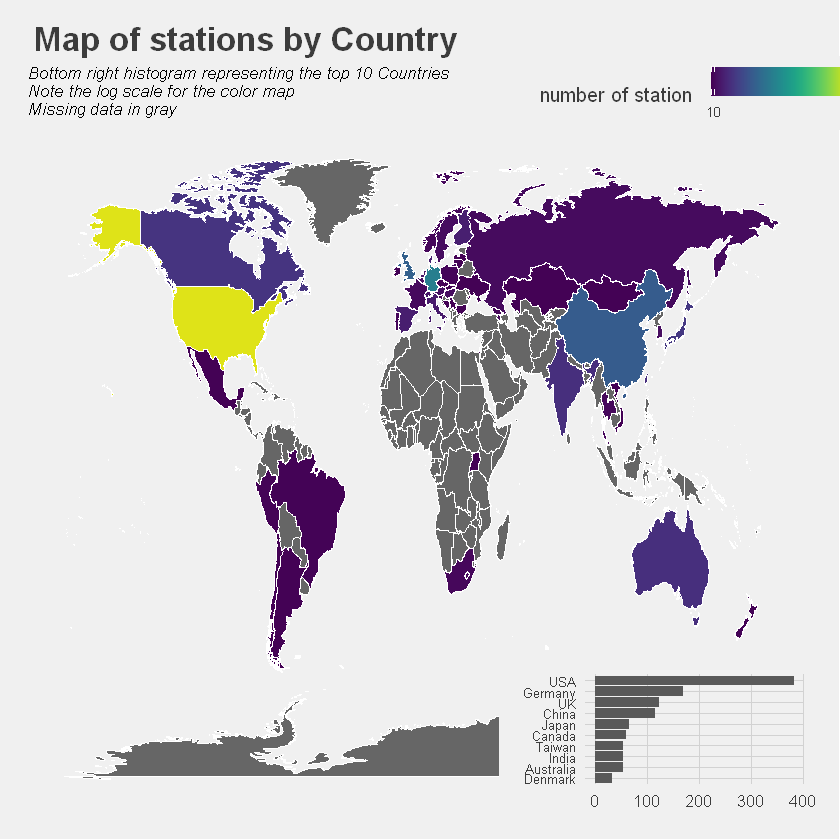

In [11]:
station_type[[1]] + annotation_custom(grob = ggplotGrob(station_type[[2]]), xmin = 45, xmax = 215, ymin = -100, ymax = -50)

- 与机场地图的报道相同，美国再次成为主导国家
- 像英国这样的老牌国家，德国跻身前十，可能是因为历史悠久的城市（伦敦）交通系统庞大。

# 对美国的航空公司数量分析

In [12]:
#temp_airlines<-data.frame(airlines %>% filter(ICAO!="" & ICAO!="\\N") %>% group_by(Country) %>% summarize(count=n()) %>% arrange(-count))
temp_airlines<-data.frame(airlines %>% 
                            group_by(Country) %>% 
                            summarize(count=n()) %>% 
                            rename(region=Country,
                                   count_airlines=count) %>%
                            arrange(-count_airlines))

#apply the same names correction
temp_airlines[temp_airlines$region=='United States','region']<-'USA'
temp_airlines[temp_airlines$region=='United Kingdom','region']<-'UK'
temp_airlines[temp_airlines$region=='Cote d\'Ivoire','region']<-'Ivory Coast'
temp_airlines[temp_airlines$region=='Congo (Kinshasa)','region']<-'Democratic Republic of the Congo'
temp_airlines[temp_airlines$region=='Congo (Brazzaville)','region']<-'Republic of Congo'

- 美国交通方式站点分布

Warning message:
"Removed 30 rows containing missing values or values outside the scale range (`geom_point()`)."


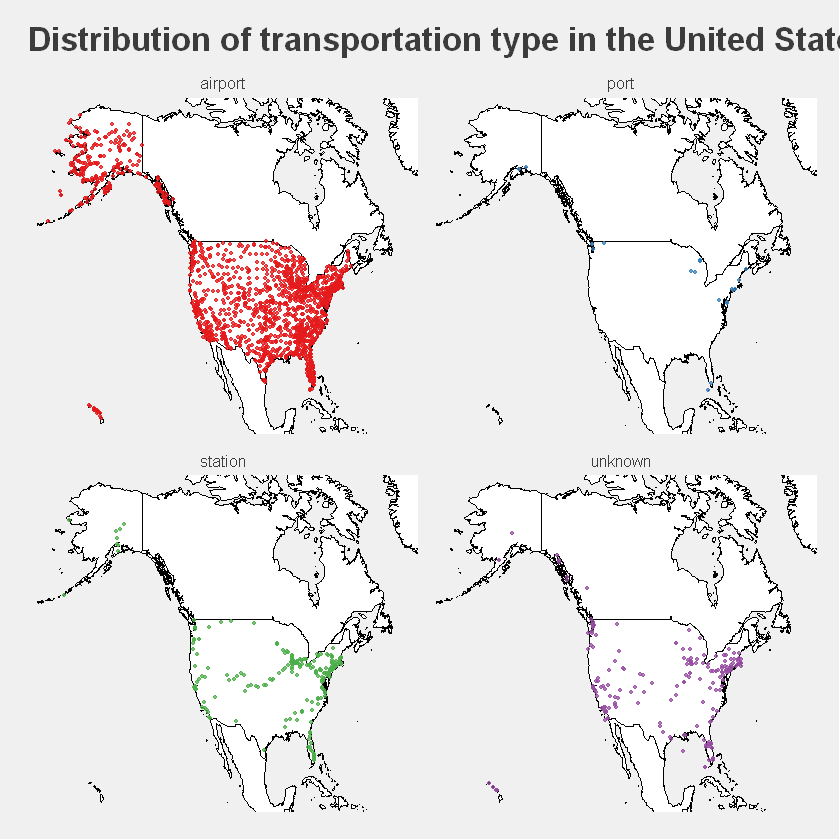

In [13]:
usa.data <-airports %>% dplyr::filter(country.name=='USA')
world_map + geom_point(data=usa.data,aes(x=long,y=lat,color=airport.type),alpha=.75,size=.75) + 
  scale_color_brewer(palette='Set1') + 
  xlim(-175,-50) + ylim(20,70) + theme_fivethirtyeight() + facet_wrap(~airport.type,ncol=2) + 
  theme(legend.position='None',
        panel.grid.major = element_blank(),
        axis.text=element_blank(),
        axis.ticks=element_blank(),
        plot.title=element_text(face="bold",hjust=.012,vjust=.8,colour="#3C3C3C",size=20),
        plot.subtitle=element_text(size=10, hjust=0, face="italic", color="black")) + 
  labs(title="Distribution of transportation type in the United States")

- 如前所述，机场是最常用的枢纽（红点密度）
- 港口（正如预期的那样！！！）位于海洋或湖泊附近。
- 这个国家的东北部有一个高密度的火车站
- 所以如果在美国想长途旅行的话，坐飞机是最方便的，在东北部的话坐火车也是不错的选择

指定机场的航线显示

In [14]:
makeConnections <- function(IATA.start){
  d1 <- data.frame(routes %>% filter(source.airport == IATA.start))
  # 修改列名
  d1.iata.start<-data.frame(d1 %>% select(destination.airport) %>% rename(IATA = destination.airport))
  #merge with the airport data，目的地
  d2<-data.frame(merge(d1.iata.start,airports %>% select(airport.name,city.name,country.name,IATA,lat,long),by='IATA', sort=F))
  colnames(d2)<-c("IATA.end","airport.name.end","city.name.end","country.name.end","lat.end","long.end")
  #获取机场地理位置
  lat.start<-rep(airports[airports$IATA==IATA.start,'lat'],nrow(d1))
  long.start<-rep(airports[airports$IATA==IATA.start,'long'],nrow(d1))
  #出发地获取
  d1$lat.start = lat.start
  d1$long.start = long.start
  #cbind all
   res<- data.frame(cbind(d1,d2))
  return(res)
}

假设我们想去纽约，想看看纽约的JFK机场航线多不多，从JFK能不能经常有飞回中国的飞机

In [15]:
jfk.start = makeConnections("JFK")

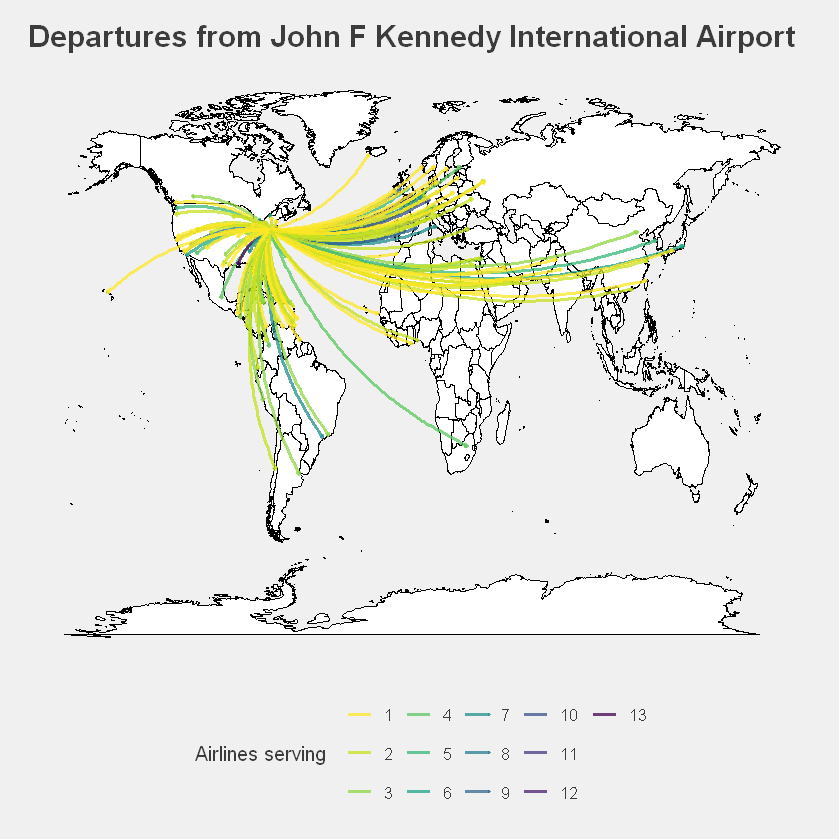

In [16]:
# 选取目的航线，按目的地进行分组，distinct（）移除重复的行
jfk.start.reduced <-jfk.start %>% select(airport.name.end ,lat.start, long.start,lat.end,long.end) %>%group_by(airport.name.end) %>% mutate(count=n()) %>% distinct()
# 获取每个目的地的最大数量，用于后续的颜色映射
maxFlights<-max(jfk.start.reduced$count)


# geom_curve 添加曲线图层绘制从JFK的航线
# viridis生成颜色值并反转颜色
world_map + 
  geom_curve(data=jfk.start.reduced,aes(x=long.start,y=lat.start,xend=long.end,yend=lat.end,color=factor(count)),curvature = 0.2, arrow = arrow(length = unit(0.005, "npc")), alpha=.75,size=1) + 
  theme_fivethirtyeight() + theme(
    panel.grid.major = element_blank(),
    axis.text=element_blank(),
    axis.ticks=element_blank()) + 
  scale_color_manual(name="Airlines serving",values=rev(viridis::viridis(maxFlights))) +
  ggtitle(paste0('Departures from ',(airports %>% filter(IATA=='JFK'))$airport.name))

为了更方便得知美国的航线，方便前往美国旅游时得到航线信息，对美国所有的航线信息进行分析

In [17]:
#描述一组航线中的机场的起始和结束位置
makeNetwork <- function(temp_routes, name){
#存空向量
  airport.start<-c()
  airport.end<-c()
  start.long<-c()
  start.lat<-c()
  end.long<-c()
  end.lat<-c()
  for(i in 1:nrow(temp_routes)){
    airport.start[i]<-temp_routes$source.airport[i]
    airport.end[i]<-temp_routes$destination.airport[i]
    start.long[i]<- airports[airports$IATA==airport.start[i],'long']
    start.lat[i]<- airports[airports$IATA==airport.start[i],'lat']
    end.long[i]<- airports[airports$IATA==airport.end[i],'long']
    end.lat[i]<- airports[airports$IATA==airport.end[i],'lat']
  }
    #创建新df返还
  res<-data.frame('airline.name' = rep(name,nrow(temp_routes)),
                  'airport.start'= airport.start,
                  'airport.end'= airport.end,
                  'airport.start.long'= start.long,
                  'airport.start.lat'= start.lat,
                  'airport.end.long'= end.long,'airport.end.lat'= end.lat)
  return(res)
}

In [18]:
#只筛选属于美国航空的所有航线，不包括运输航线
aa_df_only <- routes %>% dplyr::filter(Name=="American Airlines" & codeshare!='Y')
aa_only_routes <- makeNetwork(aa_df_only, "American Airlines")
##包括运输航线
aa_df_share <- routes %>% dplyr::filter(Name=="American Airlines" & codeshare=='Y')
aa_share_routes <- makeNetwork(aa_df_share, "American Airlines")
#merge dataframe
aa_only_routes$codeshare <- rep('No',nrow(aa_only_routes))
aa_share_routes$codeshare <- rep('Yes',nrow(aa_share_routes))
all_aa<- rbind(aa_only_routes,aa_share_routes)

#all routes
aa_df <- routes %>% dplyr::filter(Name=="American Airlines")
aa_routes <- makeNetwork(aa_df, "American Airlines")

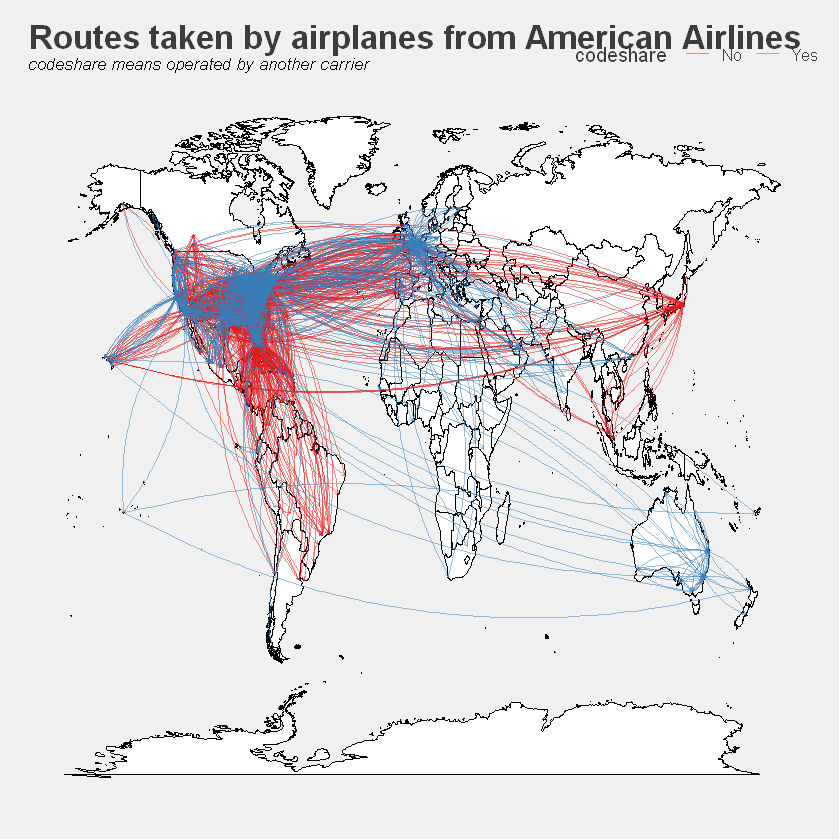

In [19]:
world_map + 
  geom_curve(data=all_aa,aes(x=airport.start.long,y=airport.start.lat,xend=airport.end.long,yend=airport.end.lat,color=codeshare),curvature = 0.2, arrow = arrow(length = unit(0.005, "npc")), alpha=.5,size=.25) + 
  theme_fivethirtyeight() +
  theme(legend.position=c(.85,1.04),
        panel.grid.major = element_blank(),
        axis.text=element_blank(),
        axis.ticks=element_blank(),
        plot.title=element_text(face="bold",hjust=.012,vjust=.8,colour="#3C3C3C",size=20),
        plot.subtitle=element_text(size=10, hjust=0, face="italic", color="black")) + 
  labs(title=paste0("Routes taken by airplanes from ",all_aa$airline.name),
    subtitle="codeshare means operated by another carrier") + 
  scale_color_brewer(palette='Set1')

In [25]:
China<-(airports %>% dplyr::filter(airport.type=='airport' & country.name == 'China' & IATA!='\\N') %>% select('IATA'))$IATA
#select the airport.start
routes %>% dplyr::filter(Name=='American Airlines') %>% filter(source.airport %in% China)

IATA,airline.ID,source.airport,source.airport.id,destination.airport,destination.airport.id,codeshare,stops,equipment,Name
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
AA,24,PEK,3364,ORD,3830,,0,777,American Airlines
AA,24,PEK,3364,SEA,3577,Y,0,787,American Airlines
AA,24,PVG,3406,LAX,3484,,0,777,American Airlines
AA,24,PVG,3406,ORD,3830,,0,777,American Airlines


In [26]:
routes %>% dplyr::filter(Name=='American Airlines') %>% filter(destination.airport %in% China)

IATA,airline.ID,source.airport,source.airport.id,destination.airport,destination.airport.id,codeshare,stops,equipment,Name
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
AA,24,LAX,3484,PVG,3406,,0,777,American Airlines
AA,24,ORD,3830,PEK,3364,,0,777,American Airlines
AA,24,ORD,3830,PVG,3406,,0,777,American Airlines
AA,24,SEA,3577,PEK,3364,Y,0,787,American Airlines


In [28]:
world_map + 
  geom_curve(data=aa_routes,aes(x=airport.start.long,y=airport.start.lat,xend=airport.end.long,yend=airport.end.lat),curvature = 0.2, arrow = arrow(length = unit(0.005, "npc")), alpha=1,size=.25) + 
  theme_fivethirtyeight() + xlim(50,200) + ylim(-50,50) + ggplot2::annotate("text", x = 131, y = 11, label = "Philippines", size=3,color='red') + ggtitle('American Airlines routes in Southeast Asia')

Warning message:
"Removed 2219 rows containing missing values or values outside the scale range (`geom_curve()`)."
ERROR while rich displaying an object: Error in if (any(x1 == x2 & y1 == y2)) stop("end points must not be identical"): missing value where TRUE/FALSE needed

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 

对于每个机场，获取每个航空公司的唯一机场数量
计算总和

In [32]:
# 用于计算从特定机场出发的唯一目的地数量
# summarize(tot = sum(count))计算总的目的地数量，as.double确保结果以双精度形式返回
countDestinations<-function(x){
    if(x!="\\N"){
    val<-routes %>% filter(source.airport == x) %>% group_by(destination.airport) %>% distinct(destination.airport) %>% summarize(count=n()) %>% summarize(tot=sum(count)) %>% as.double
    }
    else {
        val<-NA
    }
    return(val)
}
#remove NA
airports.clean <- airports %>% na.omit()
airports.clean$destinations <-sapply(airports.clean$IATA, countDestinations)

In [33]:
# geom_point使用机场的经纬度绘制点
g1<-world_map + 
  geom_point(data=filter(airports.clean,destinations>0),aes(x=long,y=lat,size=destinations,color=ifelse(destinations>25,"sup25","less25")),alpha=.6) + 
  theme_fivethirtyeight() + theme(legend.position=c(.85,1.075),
    panel.grid.major = element_blank(),
    axis.text=element_blank(),
    axis.ticks=element_blank(),plot.title=element_text(face="bold",hjust=.012,vjust=.8,colour="#3C3C3C",size=20),
    plot.subtitle=element_text(size=10, hjust=0, face="italic", color="black")) + 
  labs(
    title="Number of destinations available per Airport",
    subtitle="Airports with more than 25 destinations are represented in red\nBottom right histogram representing the top 10 Airports") + scale_color_manual(values=c("#46ACC8","#F21A00")) + 
  guides(color=F)

g2<-airports.clean %>% filter(destinations>0) %>% arrange(-destinations) %>% head(10) %>%
  ggplot(aes(x=reorder(airport.name,destinations),y=destinations)) + 
  geom_histogram(stat='identity') + coord_flip() + 
  theme_fivethirtyeight() + theme(axis.text.y = element_text(size=8))

Warning message in geom_histogram(stat = "identity"):
"Ignoring unknown parameters: `binwidth`, `bins`, and `pad`"


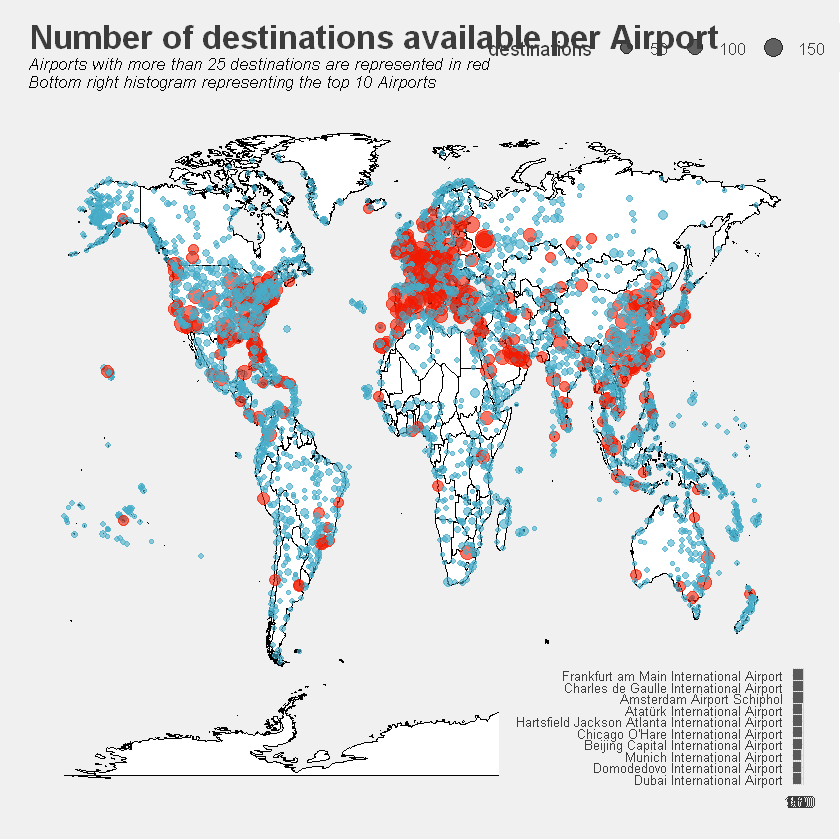

In [31]:
g1 + annotation_custom(grob = ggplotGrob(g2), xmin = 45, xmax = 215, ymin = -100, ymax = -50)

每个机场的航线目的地数量

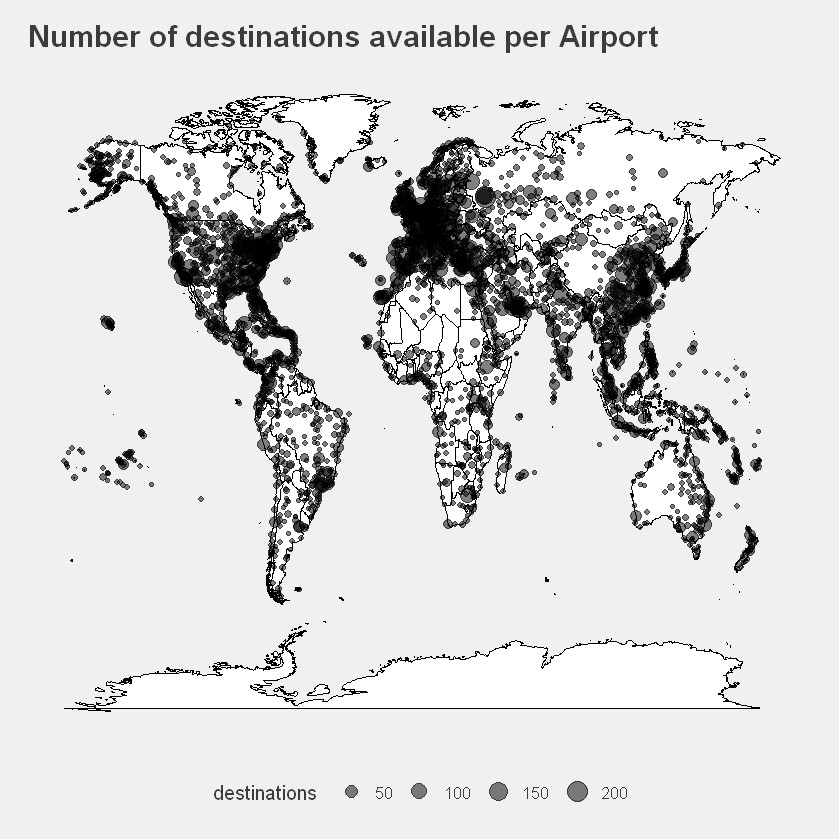

In [35]:
world_map + 
  geom_point(data=filter(airports.clean,destinations>0),aes(x=long,y=lat,size=destinations),alpha=.5) + 
  theme_fivethirtyeight() + theme(
    panel.grid.major = element_blank(),
    axis.text=element_blank(),
    axis.ticks=element_blank()) + 
  ggtitle("Number of destinations available per Airport")

最繁忙的航线：
- 能够为机场提供一些意见，若机场航线较多，可能需要修大些着陆地等等。。

In [36]:
# 计算每个航线的飞机数量占总的百分比
# strsplit分割字符串
routes$num_aircraft<-sapply(routes$equipment, function(x) length(strsplit(x," ")[[1]]))
routes %>% group_by(num_aircraft) %>% summarise(count=n()) %>% mutate(perc = 100*count / sum(count)) %>% mutate(perc = round(perc,2))

num_aircraft,count,perc
<int>,<int>,<dbl>
0,17,0.02
1,57917,74.86
2,13523,17.48
3,3792,4.90
4,1366,1.77
5,516,0.67
6,146,0.19
7,51,0.07
8,33,0.04


In [37]:
routes_7_aircrafts <- routes %>% dplyr::filter(num_aircraft==7)
routes_8_aircrafts <- routes %>% dplyr::filter(num_aircraft==8)
routes_9_aircrafts <- routes %>% dplyr::filter(num_aircraft==9)
routes_7 <- makeNetwork(routes_7_aircrafts, 'more than 6')
routes_8 <- makeNetwork(routes_8_aircrafts, 'more than 7')
routes_9 <- makeNetwork(routes_9_aircrafts, 'more than 8')
tot_routes <- rbind(routes_7, routes_8, routes_9)

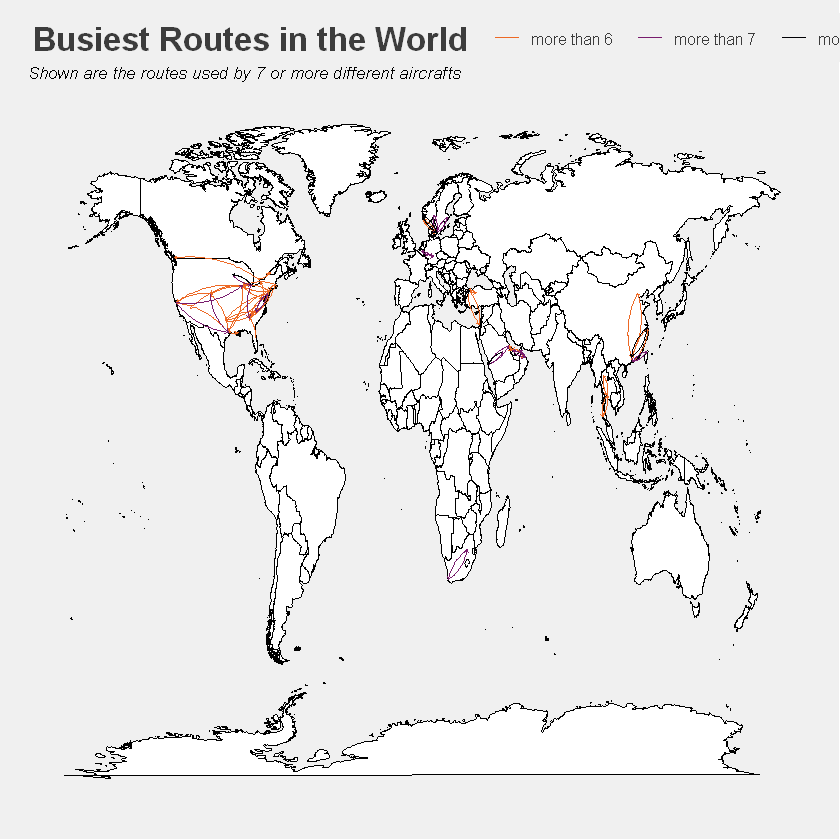

In [38]:
# panel.grid.major控制主网格线，element_blank表示移除主要网格线
world_map + 
  geom_curve(data=tot_routes,aes(x=airport.start.long,y=airport.start.lat,xend=airport.end.long,yend=airport.end.lat,color=airline.name),curvature = 0.2, arrow = arrow(length = unit(0.005, "npc")), alpha=1,size=.5) + 
  theme_fivethirtyeight() + 
  theme(
    legend.position=c(.85,1.075),
    panel.grid.major = element_blank(),
    axis.text=element_blank(),
    axis.ticks=element_blank(),plot.title=element_text(face="bold",hjust=.012,vjust=.8,colour="#3C3C3C",size=20),
    plot.subtitle=element_text(size=10, hjust=0, face="italic", color="black")) + 
  labs(
    title="Busiest Routes in the World",
    subtitle="Shown are the routes used by 7 or more different aircrafts") +
  scale_color_manual(name="",values= c("#ED6925FF" ,"#781C6DFF" ,"#000004FF"))

最常用的飞机类型

In [39]:
eq <- routes %>% select(equipment)

names<-c()
# 遍历每一行将当前行的设备列表存入cur
for (i in 1:nrow(eq)){
    cur<-eq$equipment[i]
# 通过分割cur得到每个飞机型号
    for(j in 1:length(strsplit(cur,' ')[[1]])){
        names<-append(names,strsplit(cur,' ')[[1]][j],1)
    }
}
all.aircrafts<-as.data.frame(table(names))

Warning message in geom_histogram(stat = "identity"):
"Ignoring unknown parameters: `binwidth`, `bins`, and `pad`"


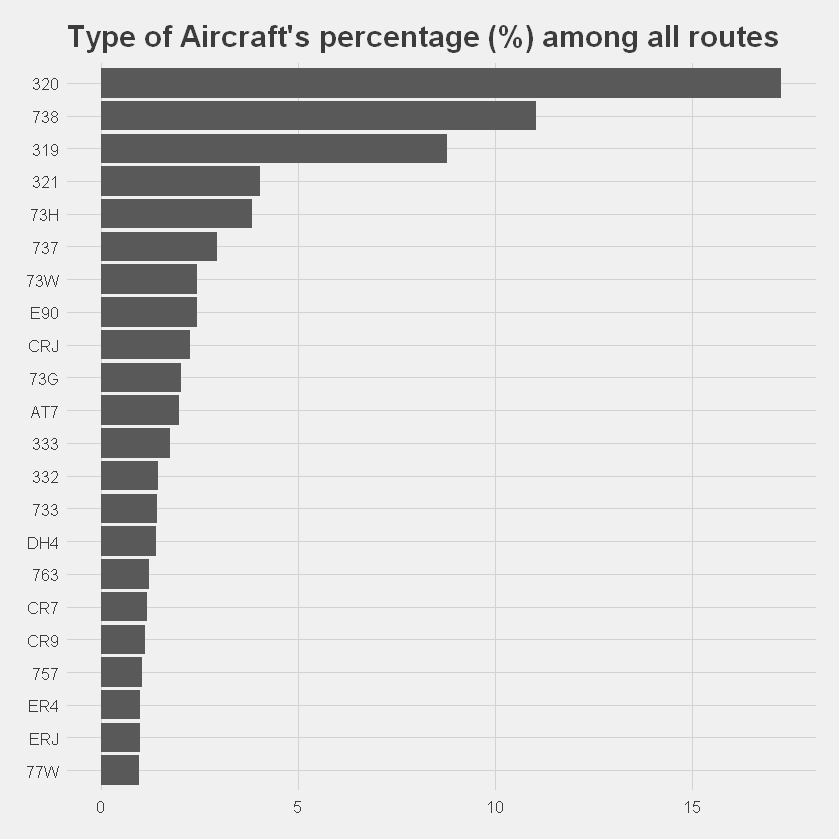

In [40]:
all.aircrafts %>% 
mutate(perc = 100* Freq/sum(Freq)) %>% 
filter(Freq>1000) %>% ggplot(aes(x=reorder(names,perc),y=perc)) + 
geom_histogram(stat='identity') + theme_fivethirtyeight() + coord_flip() + 
ggtitle('Type of Aircraft\'s percentage (%) among all routes')

最常用的飞机有：

- （airbus）320（在所有航线中占15%以上）

- 738，实际上是（波音）737-800

- （airbus）321